# Backtest Black–Scholes vs Market Quotes
This notebook pulls:
- **Underlying prices** via `data_loader.fetch_stock_data`
- **Option chains** via `yfinance`
…and compares Black–Scholes model prices to **mid quotes** for a chosen date.

We show two modes:
1. **Constant σ** (single value for all quotes)
2. **Realized σ** (rolling log-return std on the underlying)


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
plt.rcParams["font.family"] = "Times New Roman" # Set font to Times New Roman
import sys
import os

# Add the repo root (one level up from notebooks) to Python path
repo_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(repo_root)

# Local modules
from data.data_loader import fetch_stock_data, compute_annualized_volatility
from options_pricing.backtesting import (
    backtest_bs_constant_sigma,
    backtest_bs_realized_sigma,
    realized_vol_series,
)
import yfinance as yf

pd.set_option("display.float_format", lambda v: f"{v:,.6f}")


## 1) Choose a ticker and pull underlying prices

We fetch adjusted close prices for the underlying (e.g., AAPL).  
`underlying_df` must provide columns: **date** and **close**.


In [10]:
# --- 1) Underlying data ---
TICKER = "AAPL"
START = "2024-01-01"
END   = None  # to today

raw = fetch_stock_data(TICKER, start=START, end=END)  # uses auto_adjust=True internally
# Build the DataFrame expected by backtesting.py
underlying_df = (
    raw[["Close"]]
    .rename(columns={"Close": "close"})
    .reset_index()
    .rename(columns={"Date": "date"})
)
print(underlying_df.head())
print(underlying_df.tail(3))


[*********************100%***********************]  1 of 1 completed

Price        date      close
Ticker                  AAPL
0      2024-01-02 184.081512
1      2024-01-03 182.703171
2      2024-01-04 180.382828
3      2024-01-05 179.658951
4      2024-01-08 184.002167
Price        date      close
Ticker                  AAPL
416    2025-08-29 232.139999
417    2025-09-02 229.720001
418    2025-09-03 238.470001


## 2) Pull a live option chain for 1–2 expiries

`yfinance` gives the current option chain.  
We will tag all quotes with `date = latest underlying date` (today) so that `T` (time to expiry) is computed correctly.


In [11]:
# --- 2) Fetch option chain(s) for the chosen ticker ---
tk = yf.Ticker(TICKER)
expiries = tk.options
expiries = expiries[:2]  # keep it tiny; first couple of expiries

def fetch_option_chain_df(ticker, expiry, obs_date):
    """Return a tidy DataFrame with: date, expiry, strike, option_type, mid."""
    ch = yf.Ticker(ticker).option_chain(expiry)
    def prep(df, typ):
        df = df.copy()
        df["mid"] = (df["bid"] + df["ask"]) / 2.0
        df = df[["strike", "bid", "ask", "mid", "volume", "openInterest"]]
        df["option_type"] = typ
        df["expiry"] = pd.to_datetime(expiry)
        df["date"] = pd.to_datetime(obs_date)
        # Basic filters to keep usable quotes
        df = df[df["mid"].notna()]
        df = df[df["mid"] > 0]
        return df[["date", "expiry", "strike", "option_type", "mid"]]
    calls = prep(ch.calls, "call")
    puts  = prep(ch.puts,  "put")
    return pd.concat([calls, puts], ignore_index=True)

obs_date = underlying_df["date"].max()
frames = []
for ex in expiries:
    frames.append(fetch_option_chain_df(TICKER, ex, obs_date))
options_df = pd.concat(frames, ignore_index=True)

print(options_df.head())
print(options_df["expiry"].drop_duplicates().sort_values().to_list()[:5], " ...")
print(f"n_obs={len(options_df)}")


        date     expiry     strike option_type        mid
0 2025-09-03 2025-09-05 110.000000        call 128.375000
1 2025-09-03 2025-09-05 125.000000        call 113.700000
2 2025-09-03 2025-09-05 135.000000        call 103.550000
3 2025-09-03 2025-09-05 140.000000        call  98.400000
4 2025-09-03 2025-09-05 150.000000        call  88.650000
[Timestamp('2025-09-05 00:00:00'), Timestamp('2025-09-12 00:00:00')]  ...
n_obs=182


## 3) Run the backtests

We run:
- **Constant σ**: pick σ from your helper (`compute_annualized_volatility`) or just use 0.20
- **Realized σ**: rolling log-return std (window = 21 trading days)


In [12]:
# --- 3A) Constant sigma backtest ---
# Option 1: compute a simple annualized σ from the entire period
sigma_const = float(compute_annualized_volatility(raw))
# Option 2: hardcode e.g. sigma_const = 0.20

# Fix: flatten underlying_df columns to single-level
underlying_df_fixed = underlying_df.copy()
underlying_df_fixed.columns = ["date", "close"]

df_const, summary_const = backtest_bs_constant_sigma(
    options_df=options_df,
    underlying_df=underlying_df_fixed,
    sigma=sigma_const,
    r=0.03,                # fallback if 'r' not in options_df
    day_count="ACT/365",
    underlying_col="close",
)
print("Constant σ summary:", summary_const)
df_const.head()


Constant σ summary: {'n_obs': 182, 'mae': 0.1340431680767619, 'rmse': 0.22411160914354816, 'bias': 0.0234407466437383, 'sigma_mode': 'constant', 'sigma': 0.2901143689751961}


,date,expiry,option_type,strike,S,T,r,mid,sigma,theo,error,abs_error,squared_error,moneyness
0,2025-09-03,2025-09-05,call,110.000000,238.470001,0.005479,0.030000,128.375000,0.290114,128.488082,0.113082,0.113082,0.012788,0.461274
1,2025-09-03,2025-09-05,put,110.000000,238.470001,0.005479,0.030000,0.005000,0.290114,0.000000,-0.005000,0.005000,0.000025,0.461274
2,2025-09-03,2025-09-05,call,125.000000,238.470001,0.005479,0.030000,113.700000,0.290114,113.490547,-0.209453,0.209453,0.043870,0.524175
3,2025-09-03,2025-09-05,put,125.000000,238.470001,0.005479,0.030000,0.005000,0.290114,0.000000,-0.005000,0.005000,0.000025,0.524175
4,2025-09-03,2025-09-05,put,130.000000,238.470001,0.005479,0.030000,0.005000,0.290114,0.000000,-0.005000,0.005000,0.000025,0.545142


In [13]:
# --- 3B) Realized sigma backtest (rolling std) ---
df_realized, summary_realized = backtest_bs_realized_sigma(
    options_df=options_df,
    underlying_df=underlying_df_fixed,
    window=21,             # ~1 month of trading days
    r=0.03,
    day_count="ACT/365",
    underlying_col="close",
    annualization=252,
)
print("Realized σ summary:", summary_realized)
df_realized.head()


Realized σ summary: {'n_obs': 182, 'mae': 0.13520385826779613, 'rmse': 0.22704084571401362, 'bias': 0.02533769775536148, 'sigma_mode': 'realized', 'window': 21, 'annualization': 252}


,date,expiry,option_type,strike,S,T,r,mid,sigma,theo,error,abs_error,squared_error,moneyness
0,2025-09-03,2025-09-05,call,110.000000,238.470001,0.005479,0.030000,128.375000,0.291011,128.488082,0.113082,0.113082,0.012788,0.461274
1,2025-09-03,2025-09-05,put,110.000000,238.470001,0.005479,0.030000,0.005000,0.291011,0.000000,-0.005000,0.005000,0.000025,0.461274
2,2025-09-03,2025-09-05,call,125.000000,238.470001,0.005479,0.030000,113.700000,0.291011,113.490547,-0.209453,0.209453,0.043870,0.524175
3,2025-09-03,2025-09-05,put,125.000000,238.470001,0.005479,0.030000,0.005000,0.291011,0.000000,-0.005000,0.005000,0.000025,0.524175
4,2025-09-03,2025-09-05,put,130.000000,238.470001,0.005479,0.030000,0.005000,0.291011,0.000000,-0.005000,0.005000,0.000025,0.545142


## 4) Quick sanity plots

- **Parity scatter**: model (`theo`) vs market (`mid`).  
  Closer to the 45° line is better.
- **Error by moneyness**: `theo - mid` vs `K/S`.


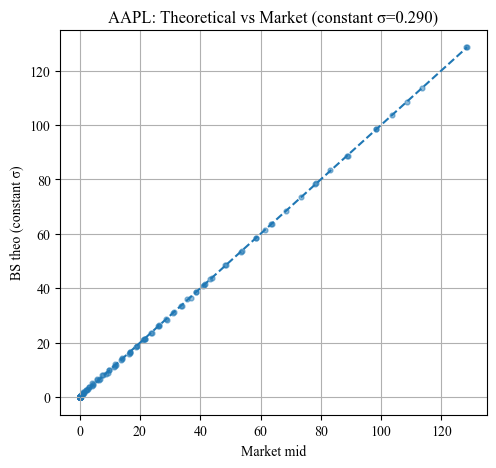

In [14]:
# --- 4A) Scatter: theo vs mid (constant σ) ---
d = df_const.dropna(subset=["theo", "mid"])
plt.figure(figsize=(5.5, 5))
plt.scatter(d["mid"], d["theo"], alpha=0.5, s=12)
mx = float(max(d["mid"].max(), d["theo"].max()))
plt.plot([0, mx], [0, mx], linestyle="--")
plt.xlabel("Market mid")
plt.ylabel("BS theo (constant σ)")
plt.title(f"{TICKER}: Theoretical vs Market (constant σ={sigma_const:.3f})")
plt.grid(True)
plt.show()


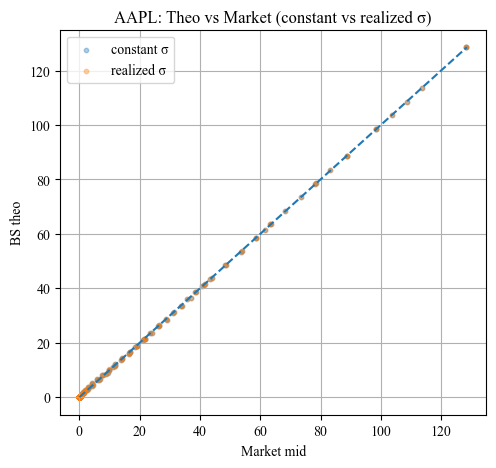

In [15]:
# --- 4B) Compare constant vs realized on parity scatter (optional) ---
d1 = df_const.dropna(subset=["theo", "mid"]).copy()
d2 = df_realized.dropna(subset=["theo", "mid"]).copy()

plt.figure(figsize=(5.5,5))
plt.scatter(d1["mid"], d1["theo"], alpha=0.35, s=10, label="constant σ")
plt.scatter(d2["mid"], d2["theo"], alpha=0.35, s=10, label="realized σ")
mx = float(max(d1["mid"].max(), d1["theo"].max(), d2["mid"].max(), d2["theo"].max()))
plt.plot([0, mx], [0, mx], linestyle="--")
plt.xlabel("Market mid")
plt.ylabel("BS theo")
plt.title(f"{TICKER}: Theo vs Market (constant vs realized σ)")
plt.grid(True)
plt.legend()
plt.show()


## 5) Notes and next steps

- The live `yfinance` chain reflects **current** quotes only. For historical chains by date you would need a vendor with historical option quotes.
- Early rows in realized-σ mode can be `NaN` if the rolling window has not filled yet; that is expected.
- To refine:
  - Filter on liquidity (min volume or open interest).
  - Bucket errors by **moneyness** and **maturity**.
  - Try alternate day-count (`ACT/252`) or rate sources.
